## Accessing Landsat Collection 2 Level-1 and Level-2 data with the Planetary Computer STAC API

The [Landsat](https://landsat.gsfc.nasa.gov/) program has been imaging the Earth since 1972; it provides a comprehensive, continuous archive of the Earth's surface.

This dataset represents the global archive of [Level-1](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-1-data) and [Level-2](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products) data from from [Landsat Collection 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2). Images are stored in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates the use of the Planetary Computer STAC API to query for Landsat data. We will start with an example using Level-2 data and follow with a similar example using Level-1 data.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [43]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import numpy as np
import matplotlib.pyplot as plt

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Choose an area and time of interest

This area is in Redmond, WA, USA, near Microsoft's main campus.

In [44]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}

We'll search all of 2021 for the least cloudy image of our area.

In [45]:
time_of_interest = "2021-01-01/2021-12-31"

### Search the collection and choose a scene to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to perform the search over the [Landsat Collection 2 Level-2](insert-actual-link) collection, specifying we want results with less than 10% cloud cover:

In [46]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 7 Items


We can now work directly with the [PySTAC](https://github.com/stac-utils/pystac) Items returned by the API. Here we find the least cloudy of the bunch.

In [47]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


### Choose  bands from that scene for composite rendering

Here we use the Item Asset keys, which are named according to the [common name](https://github.com/stac-extensions/eo#common-band-names) for their wavelength, to obtain the HREFs for red, green, and blue bands.

In [48]:
asset_hrefs = [
    selected_item.assets["SR_B4"].href,
    selected_item.assets["SR_B3"].href,
    selected_item.assets["SR_B2"].href,
]

Each HREF is a URL to the location of the asset data on [Azure Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/). In order to read the data, we'll need to retrieve a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and supply it as a query parameter. These tokens are generated from the Planetary Computer [Data Access API](https://planetarycomputer.microsoft.com/api/sas/v1/docs).

We use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to "sign" our asset HREF with a generated token:

In [49]:
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]

### Render our AOI

We can now use the HREFs to read our data in any tools that can retrieve data from URLs via HTTP GET operations. We'll use [rasterio](https://rasterio.readthedocs.io/en/latest/) to read the image data from our area of interest.

In [50]:
def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)


bands = [read_band(href) for href in signed_hrefs]

The code above reads the [Cloud Optimized GeoTIFF](https://www.cogeo.org/) data for the red, green, and blue bands separately. We will use numpy's `stack` method to turn them into the equivalent of a multiband raster, after rescaling the bands to between 0-1. We also remove extreme values during rescaling to improve the contrast of the plotted image.

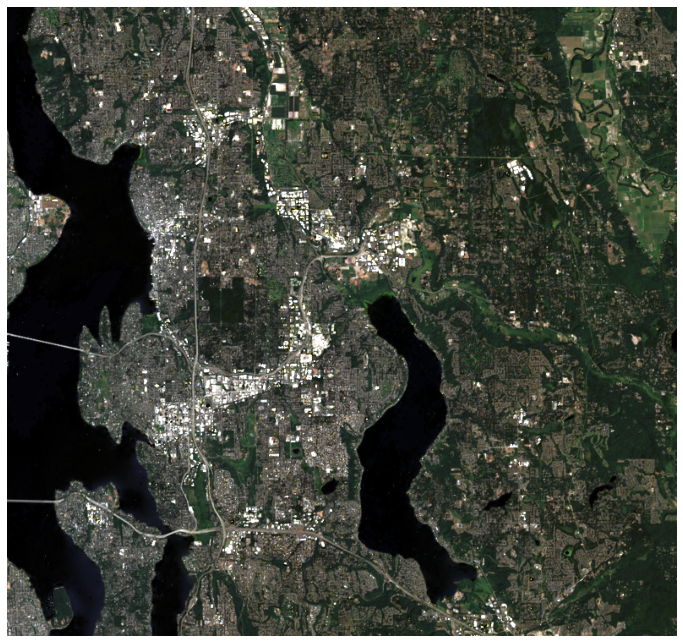

In [51]:
def rescale(band):
    rescaled = np.float32(band)
    low_percentile, high_percentile = np.percentile(rescaled, (1, 99))
    rescaled[rescaled < low_percentile] = low_percentile
    rescaled[rescaled > high_percentile] = high_percentile
    rescaled = (rescaled - low_percentile) / (high_percentile - low_percentile)
    return rescaled


rescaled_bands = [rescale(band) for band in bands]
multiband_data = np.stack(rescaled_bands)

fig = plt.figure(figsize=(12, 12))
plt.axes().set_axis_off()
plt.imshow(np.transpose(multiband_data, axes=[1, 2, 0]))

### Render an NDVI image of our AOI

Landsat has several bands, and with them we can go beyond rendering RGB imagery; for example, the following code computes a [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) using the near-infrared and red bands.

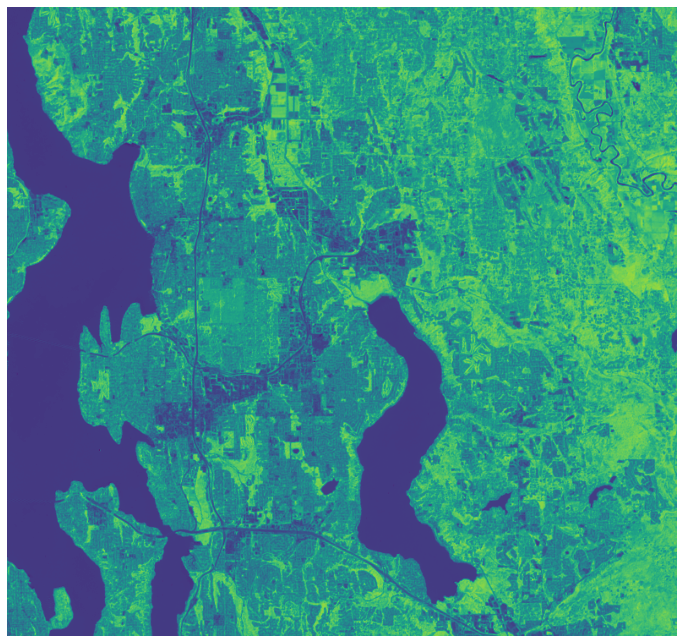

In [52]:
r = read_band(pc.sign(selected_item.assets["SR_B4"].href)).astype(float)
nir = read_band(pc.sign(selected_item.assets["SR_B5"].href)).astype(float)

ndvi = (nir - r) / (nir + r)

fig = plt.figure(figsize=(12, 12))
plt.axes().set_axis_off()
plt.imshow(ndvi, cmap="viridis")

### Landsat Collection 2 Level-1 Data

Thus far we have worked with Landsat Collection 2 Level-2 data, which is processed to a consistent set of surface reflectance and temperature [science products](https://www.usgs.gov/landsat-missions/landsat-science-products). 

The Planetary Computer also hosts Collection 2 Level-1 data, which represents top of atmosphere radiance, acquired by the [Multispectral Scanner System](https://landsat.gsfc.nasa.gov/multispectral-scanner-system/) (MSS) onboard Landsat 1 through 5. These data do not include a blue band, so a natural color image is not possible. We will plot a color infrared image from the nir08, red, and green bands instead.

As before, use pystac-client to search over the Landsat Collection 2 Level-1 collection for the same area of interest and less than 10% cloud cover:

In [53]:
search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 7 Items


Choose the least cloudy Item:

In [54]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_046027_20210725_02_T1 from 2021-07-25 with 0.38% cloud cover


Use the Asset keys to choose the nir08, red, and green bands and "sign" the Asset HREFs with Shared Access Signature tokens from the Planetary Computer data access API.

In [55]:
asset_hrefs = [
    selected_item.assets["SR_B5"].href,
    selected_item.assets["SR_B4"].href,
    selected_item.assets["SR_B3"].href,
]

signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]

Use rasterio to read the data, rescale the data, stack it into an equivalent of a multiband raster, and render the color infrared image:

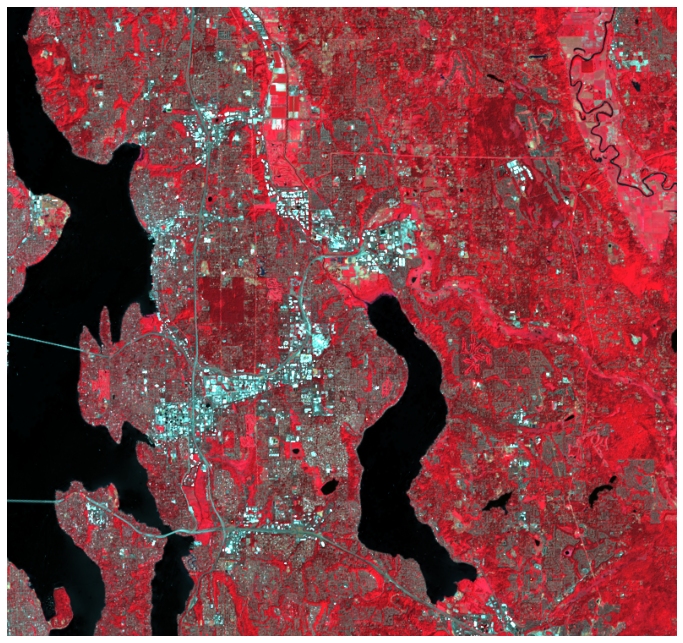

In [56]:
bands = [read_band(href) for href in signed_hrefs]
rescaled_bands = [rescale(band) for band in bands]
multiband_data = np.stack(rescaled_bands)

fig = plt.figure(figsize=(12, 12))
plt.axes().set_axis_off()
plt.imshow(np.transpose(multiband_data, axes=[1, 2, 0]))